In [1]:
from nldg.utils import *
from nldg.rf import MaggingRF_PB
from adaXT.random_forest import RandomForest

In [2]:
def mmr(
    Ytrue: np.ndarray,
    Ypred: np.ndarray,
    Yerm: np.ndarray,
    Env: np.ndarray,
    verbose: bool = False,
    ret_ind: bool = False,
) -> float | tuple[list, float]:
    mmregret = 0.0
    regret_envs = []
    for env in np.unique(Env):
        Ytrue_e = Ytrue[Env == env]
        Ypred_e = Ypred[Env == env]
        Yerm_e = Yerm[Env == env]
        regret = np.mean((Ytrue_e - Ypred_e) ** 2 - (Ytrue_e - Yerm_e) ** 2)
        regret_envs.append(regret)
        if verbose:
            print(f"Environment {env} regret: {regret}")
        mmregret = max(mmregret, regret)
    if ret_ind:
        return regret_envs, mmregret
    return mmregret

In [3]:
dtr = gen_data_v2(n=1000)
#dtr = gen_data_v3(n=1000, setting=2)
#dtr = gen_data_v4(n_easy=500, n_hard=500)
#dtr = gen_data_v5(n_samples=1000, adv_fraction=0.5, noise_var_env2=10.0)
#dtr = gen_data_v6(n=1000, noise_std=0.5)
#dtr = gen_data_v7(n=1500)
#dtr = gen_data_v8(n=1500)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 50
min_samples_leaf = 15
random_state = 42

In [4]:
sols_erm = np.zeros(Etr.shape[0])
for env in np.unique(Etr):
    mask = Etr == env
    X_e = Xtr[mask]
    Y_e = Ytr[mask]
    rf_e = RandomForest("Regression",
                        n_estimators=n_estimators,
                        min_samples_leaf=min_samples_leaf,
                        seed=random_state,)
    rf_e.fit(X_e, Y_e)
    fitted_e = rf_e.predict(X_e)
    sols_erm[mask] = fitted_e

-------------------------------------------------------
500
-------------------------------------------------------
55
-------------------------------------------------------
445
-------------------------------------------------------
418
-------------------------------------------------------
42
-------------------------------------------------------
376
-------------------------------------------------------
281
-------------------------------------------------------
59
-------------------------------------------------------
43
-------------------------------------------------------
16
-------------------------------------------------------
222
-------------------------------------------------------
130
-------------------------------------------------------
105
-------------------------------------------------------
50
-------------------------------------------------------
35
-------------------------------------------------------
15
------------------------------------------------

In [5]:
rf = RandomForest("Regression",
                  n_estimators=n_estimators,
                  min_samples_leaf=min_samples_leaf,
                  seed=random_state,
                  )
rf.fit(Xtr, Ytr)
fitted_rf = rf.predict(Xtr)
preds_rf = rf.predict(Xtr_sorted)
max_mse(Ytr, fitted_rf, Etr, verbose=True)

-------------------------------------------------------
1000
-------------------------------------------------------
985
-------------------------------------------------------
93
-------------------------------------------------------
892
-------------------------------------------------------
295
-------------------------------------------------------
248
-------------------------------------------------------
80
-------------------------------------------------------
65
-------------------------------------------------------
15
-------------------------------------------------------
168
-------------------------------------------------------
47
-------------------------------------------------------
28
-------------------------------------------------------
19
-------------------------------------------------------
597
-------------------------------------------------------
161
-------------------------------------------------------
74
-----------------------------------------------

np.float64(0.2823785122911624)

In [6]:
mmr(Ytr, fitted_rf, sols_erm, Etr, verbose=True)

Environment 0 regret: 0.238765615084891
Environment 1 regret: 0.24075920261202816


np.float64(0.24075920261202816)

In [7]:
rf_maximin = RandomForest("MaximinRegression",
                          n_estimators=n_estimators,
                          min_samples_leaf=min_samples_leaf,
                          seed=random_state,
                          )
rf_maximin.fit(Xtr, Ytr, Etr, sols_erm)
fitted_maximin = rf_maximin.predict(Xtr)
preds_maximin = rf_maximin.predict(Xtr_sorted)
max_mse(Ytr, fitted_maximin, Etr, verbose=True)

0.030963642573037537 0.30963642573037536
[3.610612] 0.3406000683034129
-------------------------------------------------------
1000
Remaining:  0 [0. 0.]
Best split:  502 5.097334350686499
Impurity:  0.3406000683034129 0.29473920774647694
Best values:  [3.607351342514624, 3.6607826211845507]
Best preds:  (array([3.60735134, 3.66078262]), array([502, 498]))
-------------------------------------------------------
498
Remaining:  502 [ 58.30521037 120.00970087]
Best split:  30 7.84440354144463
Impurity:  0.29473920774647694 0.2896988514993096
Best values:  [3.155294842989044, 3.6612629632206337]
Best preds:  (array([3.15529484, 3.60735134, 3.66126296]), array([ 30, 502, 468]))
-------------------------------------------------------
468
Remaining:  532 [ 60.17926439 120.90210488]
Best split:  375 10.209741234368945
Impurity:  0.2896988514993096 0.2810436559237407
Best values:  [3.6874899903889116, 3.39016908019584]
Best preds:  (array([3.15529484, 3.39016908, 3.60735134, 3.68748999]), arra

np.float64(0.28724917037347664)

In [8]:
mmr(Ytr, fitted_maximin, sols_erm, Etr, verbose=True)

Environment 0 regret: 0.2459337807831484
Environment 1 regret: 0.23922634948698554


np.float64(0.2459337807831484)

In [9]:
rf_magging = MaggingRF_PB(n_estimators=n_estimators,
                          min_samples_leaf=min_samples_leaf,
                          random_state=random_state,
                          backend='adaXT',
                          )
fitted_magging, preds_magging = rf_magging.fit_predict_magging(Xtr, Ytr, Etr, Xtr_sorted)
wmag = rf_magging.get_weights()
max_mse(Ytr, fitted_magging, Etr, verbose=True)

-------------------------------------------------------
500
-------------------------------------------------------
55
-------------------------------------------------------
445
-------------------------------------------------------
418
-------------------------------------------------------
42
-------------------------------------------------------
376
-------------------------------------------------------
281
-------------------------------------------------------
59
-------------------------------------------------------
43
-------------------------------------------------------
16
-------------------------------------------------------
222
-------------------------------------------------------
130
-------------------------------------------------------
105
-------------------------------------------------------
50
-------------------------------------------------------
35
-------------------------------------------------------
15
------------------------------------------------

np.float64(0.7147317637917893)

In [10]:
mmr(Ytr, fitted_magging, sols_erm, Etr, verbose=True)

Environment 0 regret: 0.6734163742014612
Environment 1 regret: 0.6658231393582993


np.float64(0.6734163742014612)

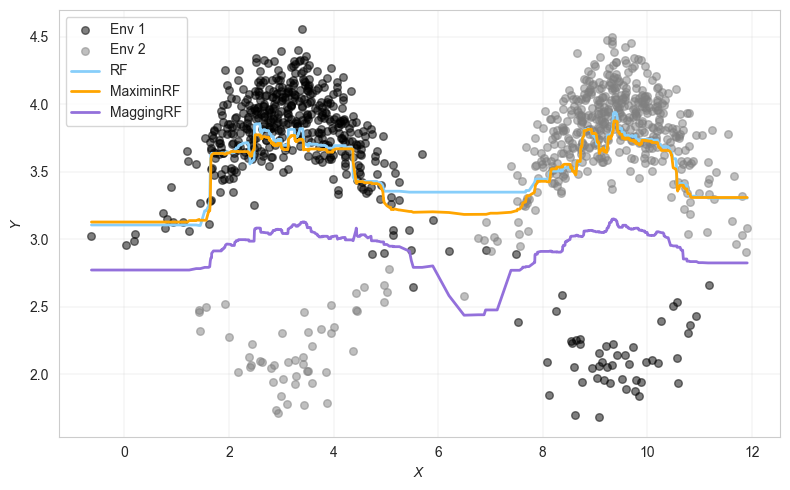

In [11]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_maximin"] = preds_maximin
dtr["fitted_magging"] = preds_magging

plot_dtr(dtr)